In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


# Identifiy the distribution of the upper tiertile of the krill population based on both KRILLPODYM and KRILLBASE data

We use both sources of krill distribution (only circumpolar data of krill pop, but different nature : krillbase are net sampling data over a long time serie with nan (areas not sampled) and krillpodym is a newly mechanistic model of the krill population).

To have more confidence in KAKS (derived from uppertiertile of krill pop and seq time), we combine both krillbase and krillpodym: the goal is to identifiy the cells that are identified as uppertiertile by both datasets or only one of the two).

#### Load data

In [2]:
# load krillpodym and krillbase  formated
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')

krill_base = pd.read_csv('./Krill_density_krillbase_df_final.csv').rename(columns = {'LONGITUDE_largegrid' : 'longitude' , 'LATITUDE_largegrid' : 'latitude'})[['latitude', 'longitude', 'STANDARDISED_KRILL_UNDER_1M2_log']]
krill_podym = pd.read_csv('./Krill_biomass_df_final.csv')[['latitude', 'longitude', 'krill_adult_log']]

In [3]:
krill_base = krill_base.dropna() # here do not drop 0 bc "true 0", not like in krillpodym
krill_base.set_index(['latitude', 'longitude'], inplace = True) # 1063  

krill_podym = krill_podym.dropna()[krill_podym['krill_adult_log'] != 0] # remove 0 bc Nan of krillbase are 0 of krillpodym
krill_podym.set_index(['latitude', 'longitude'], inplace = True) # 1648  

C:\Users\anael\AppData\Local\Temp\ipykernel_42316\2826894241.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  krill_podym = krill_podym.dropna()[krill_podym['krill_adult_log'] != 0] # remove 0 bc Nan of krillbase are 0 of krillpodym


#### 1/3 quantiles

In [4]:
krill_podym_quantiles = krill_podym.quantile(q=[0.3333, 0.6666])
krill_base_quantiles = krill_base.quantile(q=[0.3333, 0.6666])

UpT_krillpodym = float(krill_podym_quantiles.iloc[1])
UpT_krillbase = float(krill_base_quantiles.iloc[1])

C:\Users\anael\AppData\Local\Temp\ipykernel_42316\3951868741.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UpT_krillpodym = float(krill_podym_quantiles.iloc[1])
C:\Users\anael\AppData\Local\Temp\ipykernel_42316\3951868741.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UpT_krillbase = float(krill_base_quantiles.iloc[1])


##### Add a column that indicated if the cell is in the upper titer tile

In [5]:
krill_podym['UpTiertile_P'] = np.where(krill_podym['krill_adult_log'] > UpT_krillpodym, 1, 0)
krill_base['UpTiertile_B'] = np.where(krill_base['STANDARDISED_KRILL_UNDER_1M2_log'] > UpT_krillbase, 1, 0)

#### Join and select cells according to their status in each datasets (in or out the upper tiertile)

In [6]:
krill_pop = krill_podym.join(krill_base, how='outer')
krill_pop

krill_adult_log  UpTiertile_P  \
latitude longitude                                  
-77      -179               0.57452           0.0   
         -177               0.81818           0.0   
         -175               1.00264           0.0   
         -173               0.99747           0.0   
         -171               1.14972           0.0   
...                             ...           ...   
-45       63                0.00001           0.0   
          65                0.00762           0.0   
          67                0.10288           0.0   
          69                0.05762           0.0   
          71                0.00012           0.0   

                    STANDARDISED_KRILL_UNDER_1M2_log  UpTiertile_B  
latitude longitude                                                  
-77      -179                                    NaN           NaN  
         -177                                    NaN           NaN  
         -175                                    NaN           NaN  
         -173                                    NaN           NaN  
         -171                                    NaN           NaN  
...                                              ...           ...  
-45       63                                     NaN           NaN  
          65                                     NaN           NaN  
          67                                     NaN           NaN  
          69                                     NaN           NaN  
          71                                     NaN           NaN  

[1905 rows x 4 columns]

In [14]:
krill_pop.corr() # 0.375020 of correlation between krillpodym and krillbase (but here what matters is the ranking of the cells)

,krill_adult_log,UpTiertile_P,STANDARDISED_KRILL_UNDER_1M2_log,UpTiertile_B,label
krill_adult_log,1.000000,0.744638,0.375020,0.357327,0.713451
UpTiertile_P,0.744638,1.000000,0.353061,0.350371,0.847845
STANDARDISED_KRILL_UNDER_1M2_log,0.375020,0.353061,1.000000,0.886332,0.802573
UpTiertile_B,0.357327,0.350371,0.886332,1.000000,0.890726
label,0.713451,0.847845,0.802573,0.890726,1.000000


In [16]:
def label(UpTiertile_P, UpTiertile_B):
    # both agree
    if (UpTiertile_P == 1) and (UpTiertile_B == 1):
        return 3
    # one has no data    
    if (UpTiertile_P == 1) and pd.isna(UpTiertile_B):
        return 3
    if pd.isna(UpTiertile_P) and (UpTiertile_B == 1):
        return 3
    # diverging answers    
    if (UpTiertile_P == 1) and (UpTiertile_B == 0):
        return 2
    if (UpTiertile_P == 0) and (UpTiertile_B == 1):
        return 2.5
    # both agree    
    if (UpTiertile_P == 0) and (UpTiertile_B == 0):
        return 1
    # one has no data
    if pd.isna(UpTiertile_P) and (UpTiertile_B == 0):
        return 1
    if (UpTiertile_P == 0) and pd.isna(UpTiertile_B):
        return 1

In [17]:
krill_pop['label'] = krill_pop.apply(lambda row: label(row['UpTiertile_P'], row['UpTiertile_B']), axis=1)
krill_pop['label'].unique()

array([1. , 3. , 2. , 2.5])

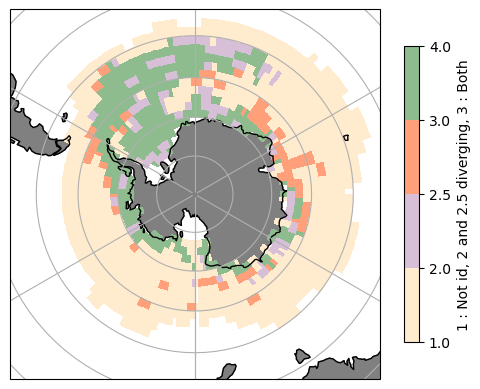

In [18]:
krill_pop_xarray = xr.Dataset.from_dataframe(krill_pop)
krill_pop_xarray

os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures')
map_proj = ccrs.SouthPolarStereo()

p = krill_pop_xarray["label"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 2.5, 3, 4], 
    colors = ['blanchedalmond', 'thistle', 'lightsalmon', 'darkseagreen', 'darkgreen']#['navajowhite', 'thistle', 'indianred', 'blue']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "1 : Not id, 2 and 2.5 diverging, 3 : Both" , shrink = 0.8)
plt.title('') # Upper tier-tile of krill density of KRILLBASE [nb indiv/m²] and/or KRILLPODYM [g/m²] (in scale log(x+1))

plt.savefig('UQ_krillbaseVSkrillpodym.png')

## Conclusion
In green, all the cells that are identified as Upper tiertile of krill density by both datasets. 
It is mainly cells where both models agree  + where there is the UQ of krillpodym but krillbase has no values available.
There are a few cells (5) that are cells in the UQ of krillbase but have no data in KRILLPODYM (its because the cells are almost on land and krillpodym has no values there). This few cells are lost in the biplot bc we use krillpodym values.

orange and purple cells are cells where both krillpodym and krillbase have available data but their are diverging:
In purple, in the UQ of krillpodym but not krillbase. Organce cells are in the UQ of krillbase but not krillpodym

In yellow, both datasets agree that the cells are not in the UQ. 

**=> From now the green cells are kept as the "consensus UQ of krill distribution"**

# Show the confidence level of the UQ identified with both datasets (green)

% of the green (UQ) area that is identified by both, one or the other datasets.

In [37]:
UQ = krill_pop[krill_pop['label'] == 3]  # 468 rows

def classify(row):
    if row['UpTiertile_P'] == 1 and row['UpTiertile_B'] == 1:
        return 3
    elif row['UpTiertile_P'] == 1 and (row['UpTiertile_B'] != 1 or np.isnan(row['UpTiertile_B'])):
        return 2
    else:
        return 1

UQ['label'] = UQ.apply(classify, axis=1)

C:\Users\anael\AppData\Local\Temp\ipykernel_42316\634693631.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UQ['label'] = UQ.apply(classify, axis=1)


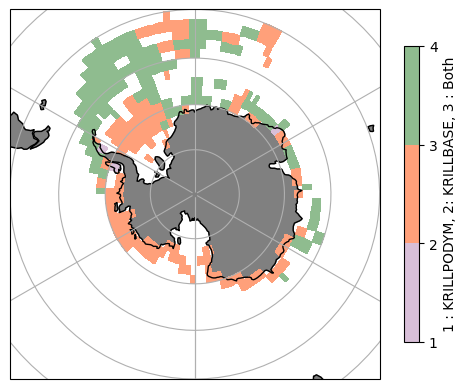

In [53]:
UQ_xarray = xr.Dataset.from_dataframe(UQ).sortby("latitude").sortby("longitude")
UQ_xarray

os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures')
map_proj = ccrs.SouthPolarStereo()

p = UQ_xarray["label"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4], 
    colors = ['thistle', 'lightsalmon', 'darkseagreen']#['navajowhite', 'thistle', 'indianred', 'blue']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "1 : KRILLPODYM, 2: KRILLBASE, 3 : Both" , shrink = 0.8)
plt.title('') # Upper tier-tile of krill density of KRILLBASE [nb indiv/m²] and/or KRILLPODYM [g/m²] (in scale log(x+1))

#plt.savefig('UQ_confidence.png')

#### Add the areas if cell to calculate the % of area in each category

In [44]:
# load the formated file of ocim
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')

area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])
area_df['True_area'] = area_df['AREA']*area_df['MASK']

In [49]:
UQ = UQ.join(other = area_df[['True_area']], how = 'left')

UQ_bygroup = UQ.groupby(['label']).sum()
UQ_bygroup

,krill_adult_log,UpTiertile_P,STANDARDISED_KRILL_UNDER_1M2_log,UpTiertile_B,True_area
label,,,,,
1,0.00000,0.0,6.229091,6.0,6.564730e+09
2,542.06824,255.0,0.000000,0.0,3.784057e+12
3,396.44554,207.0,308.738115,207.0,4.741085e+12


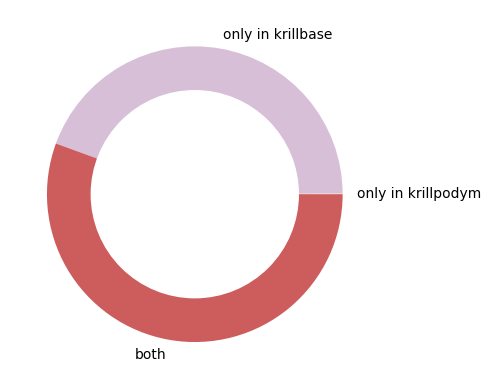

In [51]:
# plot % of each category
names = ['only in krillpodym', 'only in krillbase', 'both']
plt.pie(UQ_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

# Save the datasets krill_pop to use it in the KAKS idntification

In [42]:
# create a column with the krillpop 
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')
#os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data')
krill_pop.to_csv('UpTiertile_krill_pop.csv')